In [4]:
import pandas as pd
from itertools import product

#parameters for all models
layersize_list = [2048]
epoch_list = [2048] #[ 64, 256, 1024 ]:
depth_list = [2]

#parameters for the pod model
pod_dim_list = [11]
#print(pod_dim_list)

#parameters for the auto-encoder
#(these will actually be applied to the model; 
#the above parameters will applied to the auto-encoder itself since it's doing most of the work)
ac_mod_ls_list = [20, 40] #[ 8, 32, 128, 512 ]
ac_mod_ep_list = [ 50, 100 ] #[ 64, 256, 1024 ]:


d = []
#for ep in epoch_list:
#  for ls = layersize_list:
for ls, ep, de in product(layersize_list,epoch_list,depth_list):
    #full model
    d.append( { 'model':  'full', 'layersize': ls, 'epochs': ep, 'depth': de })

#     #pod
#     for pod_dim in pod_dim_list:
#         d.append( { 'model':  'pod', 'layersize': ls, 'epochs': ep, 'depth': de, 'pod_dim': pod_dim })

    # #autoencoder
    # for mod_ls, mod_ep in product(ac_mod_ls_list,ac_mod_ep_list):
    #     ac_dim = ls // 2 
    #     d.append( { 'model':  'ac', 'layersize': mod_ls, 'epochs': mod_ep, 'ac_layersize': ls, 'ac_epochs': ep, 'ac_dim': ac_dim })

#convert to dataframe
df = pd.DataFrame(d)

#export to csv
df.to_csv('timing_cases.csv', encoding = 'utf-8', index=False)

zeta = pd.read_csv('Zeta.csv')
keys = zeta.columns
values = '_'+zeta.columns+'.'
my_dict = dict(zip(keys,values))
zeta = zeta.rename(columns=my_dict)


Starting:
  model layersize epochs depth
0  full      2048   2048     2


TypeError: unsupported operand type(s) for +=: 'int' and 'list'

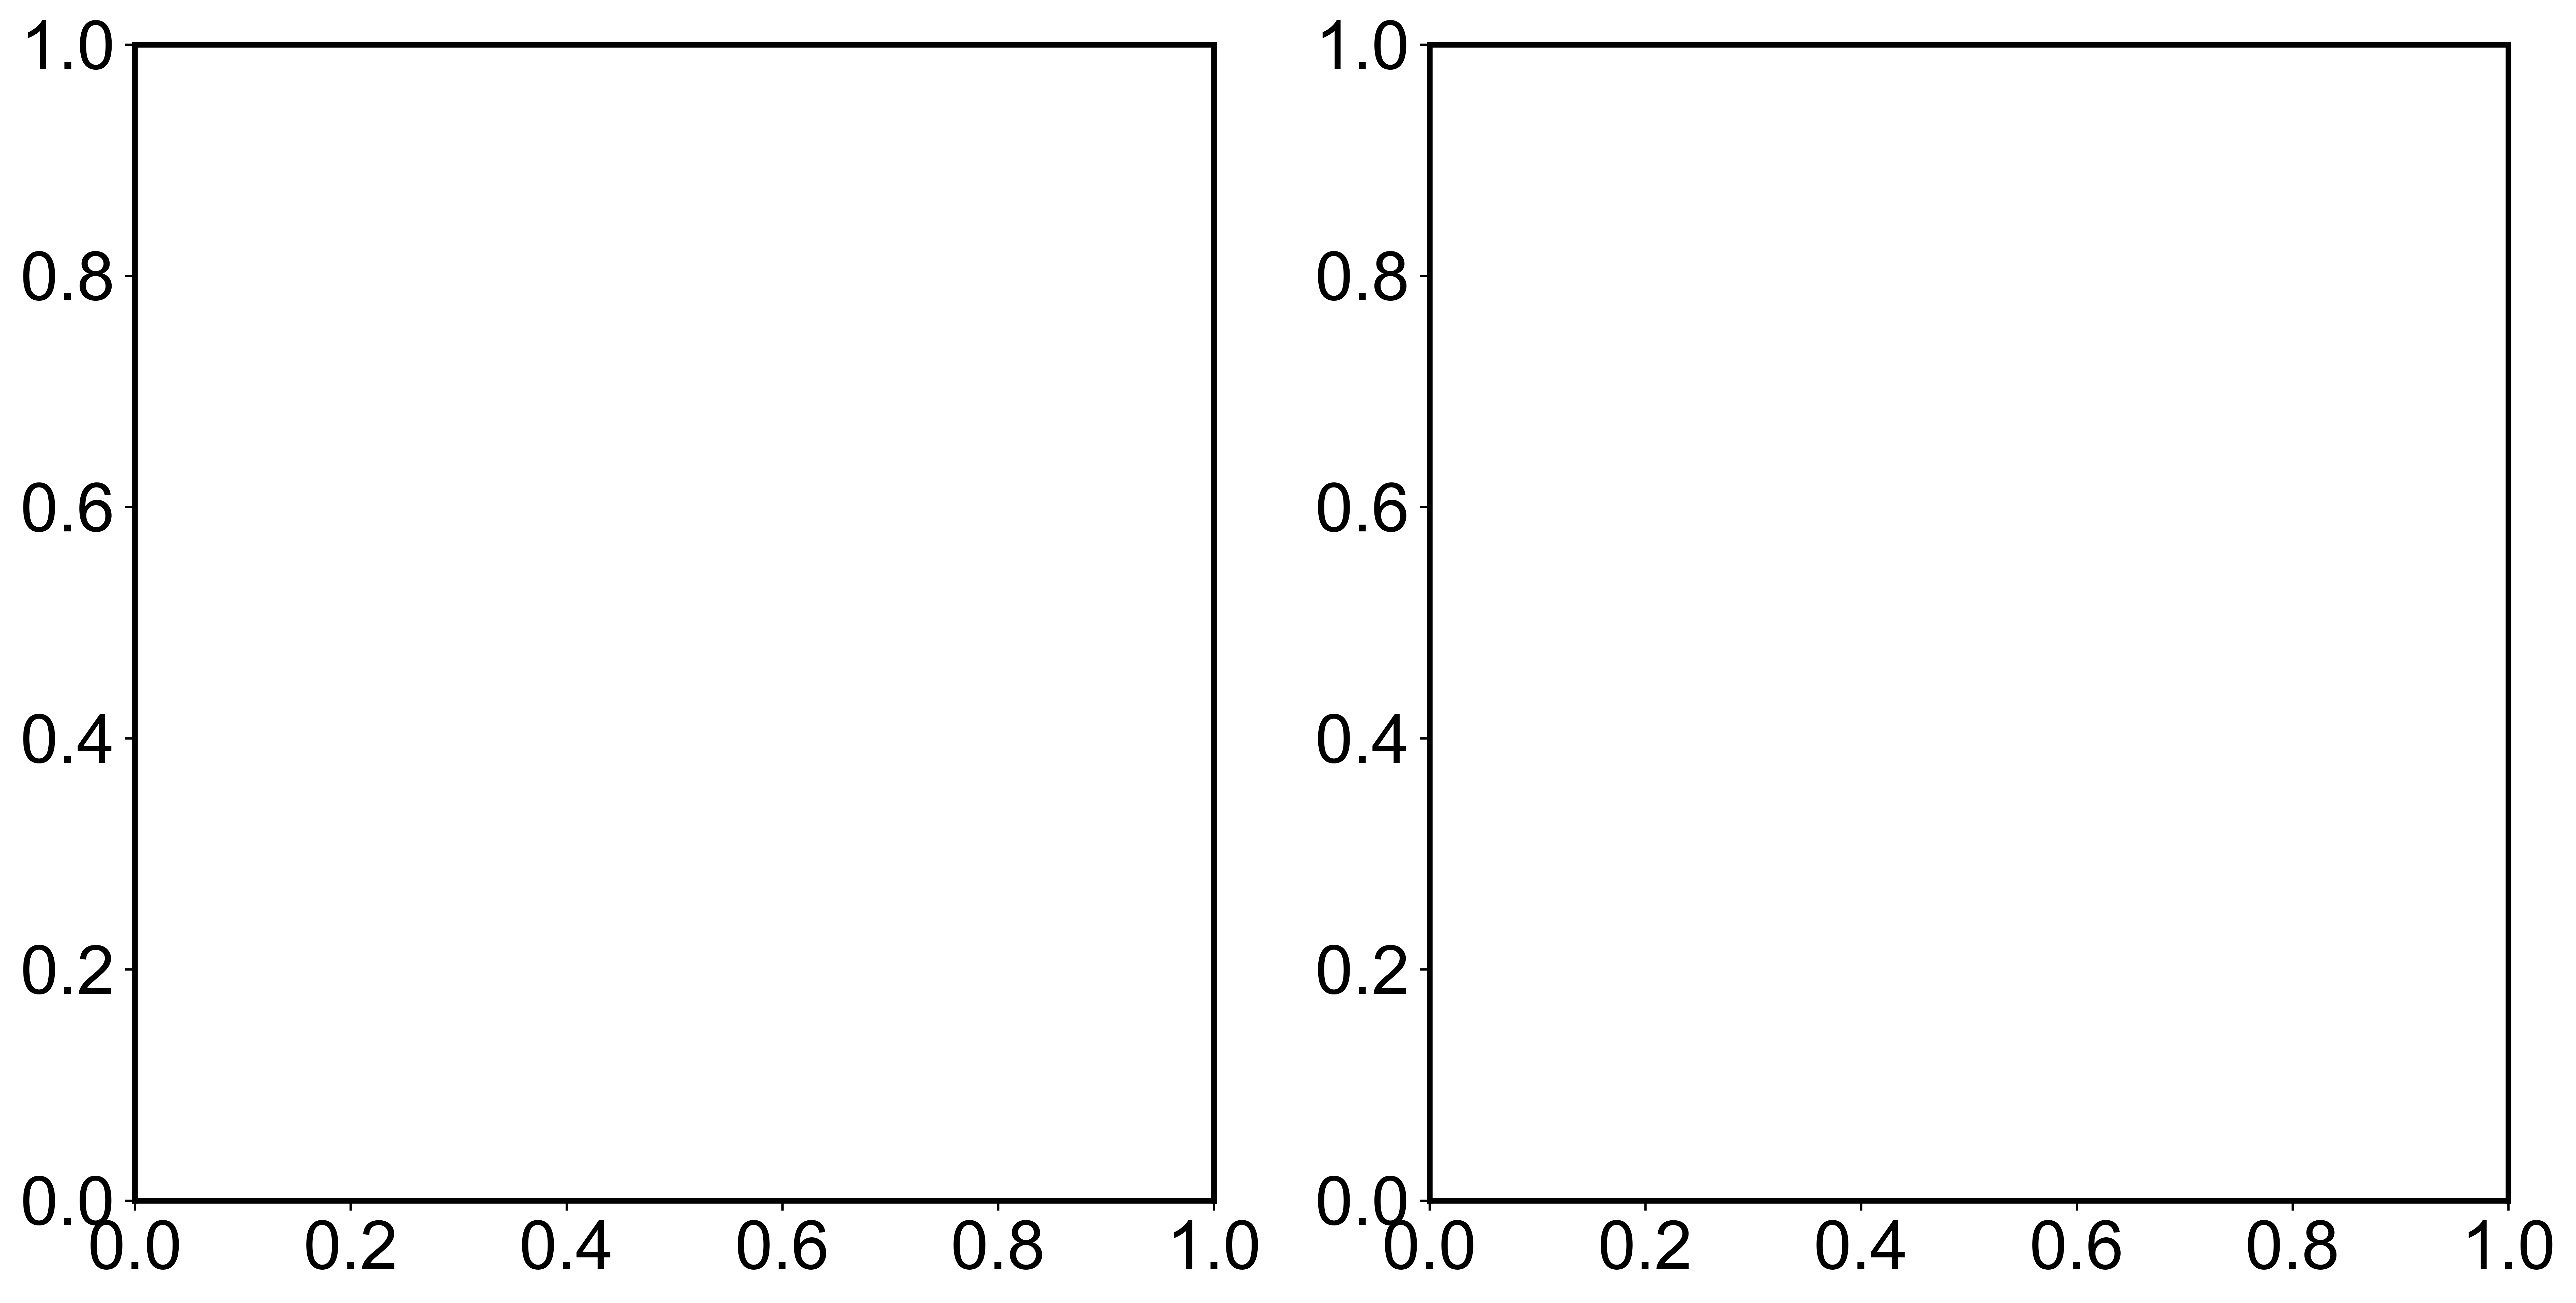

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import time
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.utils import shuffle
from keras import callbacks

#tf.keras.backend.set_floatx('float64')

# Declare Cross-Fold Validation Split / Model Params
N_SPLIT = 10
TIMING_REPS = 50

xfile = 'ML_inputs_tear.csv'
yfile = 'U_tear.csv'
casefile = 'timing_cases.csv'


# Read Data
xdf = pd.read_csv(xfile)
ydf = pd.read_csv(yfile)

# # Adding Constant Parameters to X data
# xdf.insert(0, 'c', 6)
# xdf.insert(1, 'D', .05)
# xdf.insert(2, 'k1', 15)
# xdf.insert(3, 'k2', 15)
# xdf.insert(4, 'N', 2)
# xdf.insert(5, 'kappa_1', .25)
# xdf.insert(6, 'kappa_2', .25)
# xdf.insert(7, 'kappa_3', .25)


# Convert to Array
x = xdf.to_numpy()
y = ydf.T.to_numpy()

n = x.shape[1] #number of datasets

#function to create a deep neural network
def create_dnn(layersize,insize,outsize,depth):
    model_list = [tf.keras.layers.Dense(insize), tf.keras.layers.Dense(outsize)]
    model_list[1:1] = [tf.keras.layers.Dense(layersize, 'sigmoid')]*depth
    
    model = tf.keras.Sequential(model_list)
    model.compile(optimizer = 'adam', loss = 'mse')
    return model

#autoencoder class
class Autoencoder(tf.keras.models.Model):
    def __init__(self, layersize,insize,dim,layertype='sigmoid'):
        super(Autoencoder, self).__init__()
        self.dim = dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(insize),
            tf.keras.layers.Dense(layersize, layertype),
            tf.keras.layers.Dense(layersize, layertype),
            tf.keras.layers.Dense(dim)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(layersize, layertype),
            tf.keras.layers.Dense(layersize, layertype),
            tf.keras.layers.Dense(insize)
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

#pod "encoder" and "decoder"
def podEncode(Ur,Sr):
    #yr = np.matmul(Ur,np.sqrt(np.diag(Sr)))
    yr = np.matmul(Ur,np.diag(Sr))
    return yr

def podDecode(yr,Sr,Vhr):
    #y = np.matmul(np.matmul(yr,np.sqrt(np.diag(Sr))),Vhr)
    y = np.matmul(yr,Vhr)
    return y

#compute relative error per input
def relative_error(y,pred):
    #nums   = np.array( [ np.linalg.norm(y[j,:]-pred[j,:],2)**2 for j in range(n) ] )
    #denoms = np.array( [ np.linalg.norm(y[j,:],2)**2 for j in range(n) ] )
    nums   = np.sum((y-pred)**2, axis=1) #numerators
    denoms = np.sum((y     )**2, axis=1) #denominators
    rel_err = np.sqrt( sum(nums / denoms) )
    return rel_err

# read timing cases to run
tcases = pd.read_csv(casefile)

# add columns
tcases.assign(off_time_mean = 0.0)
tcases.assign(off_time_med  = 0.0)
tcases.assign(off_time_std  = 0.0)
tcases.assign(on_time_mean  = 0.0)
tcases.assign(on_time_med   = 0.0)
tcases.assign(on_time_std   = 0.0)
tcases.assign(rel_err_mean  = 0.0)
tcases.assign(rel_err_med   = 0.0)
tcases.assign(rel_err_std   = 0.0)

mcases = pd.DataFrame(columns = ['depth', 'layer size', 'offline time', 'online time', 'relative error'])

# #EPOCHS = 100
# #LAYERSIZE = 1000
# for EPOCHS in [ 100 ]:#[ 64, 256, 1024 ]:
#   for LAYERSIZE = [ 10, 40 ]: #[ 8, 32, 128, 512 ]
#for tcase in tcases:
for i, tcase in tcases.iterrows():

    print("Starting:")
    print(tcase.to_frame().T)

    modeltype = tcase['model']
    layersize = tcase['layersize']
    depth     = tcase['depth']
    epochs    = tcase['epochs']
#     patience = math.log(layersize, 2)*10
    # Train models
    m            = []
    offline_time = []
    online_time  = []
    rel_err      = []
    modelhistories = []
    
    for train_index, test_index in model_selection.KFold(N_SPLIT, shuffle=True).split(x):
    #for iModel, (train_index, test_index) in enumerate(model_selection.KFold(N_SPLIT, shuffle=True).split(x)):
        #split
        xtrain, xtest = x[train_index], x[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        
#         earlystop = callbacks.EarlyStopping(
#             monitor="val_loss", patience=patience, 
#             mode="min", restore_best_weights=True
#         )
        
        start = time.time()
        if modeltype == 'full':
            with tf.device('/CPU:0'):
            #Create model
                model = create_dnn(layersize,x.shape[1],y.shape[1],depth)
            
                #print("TensorFlow is using the following GPUs:",tf.config.list_physical_devices('GPU'))
            #Fit model
                history = model.fit(
                                    xtrain, ytrain, epochs = epochs, verbose = 0, 
                                    validation_data = (xtest, ytest)#, callbacks = [earlystop]
                                    )
            modelhistories.append(history)
        elif modeltype == 'pod':
            pod_dim = int(tcase['pod_dim'])
            #SVD Decomposition
            u, s, vh = np.linalg.svd(ytrain, full_matrices = False);
            
            #Truncate to specified dimension
            Sr   = s[:pod_dim]
            Ur   = u[:,:pod_dim]
            Vhr  = vh[:pod_dim,:]
            
            #yPod = np.matmul(Ur,np.sqrt(np.diag(Sr))) #scale with sqrt(sv)
            yPod = podEncode(Ur,Sr)
            
            with tf.device('/CPU:0'):
                #Create model
                model = create_dnn(layersize,x.shape[1],pod_dim,depth)
                
                #Fit model
                history = model.fit(
                                    xtrain, yPod, epochs = epochs, verbose = 0#, validation_data = (xtest, yPod_val)
                                    #, callbacks = [earlystop]
                                    )
            modelhistories.append(history)    
        elif modeltype == 'ac':
            #Build Model
            ac_dim       = int(tcase['ac_dim'])
            ac_layersize = int(tcase['ac_layersize'])
            ac_epochs    = int(tcase['ac_epochs'])
            #Build Autoencoder
            autoencoder = Autoencoder(ac_layersize,y.shape[1],ac_dim,depth)
            autoencoder.compile(optimizer = 'adamax', loss = 'mse')
            autoencoder.fit(y, y, epochs = ac_epochs, verbose = 0)
            #Create model
            model = create_dnn(layersize,x.shape[1],ac_dim)
            #Fit model
            encoded = autoencoder.encoder.predict(y)
            ytrain, ytest = encoded[train_index], encoded[test_index]
            model.fit(xtrain, ytrain, epochs = epochs, verbose = 0)
        else:
            print("modeltype",modeltype,"not supported")
        
        end = time.time()
        off_temp = end - start
        offline_time.append(off_temp)
        
#         epochs_best1 = np.argmin(model.history.history["val_loss"])
        
#         assert (epochs_best1 < epochs-patience), "Model did not converge in "+str(epochs)+" epochs."
#         print("Model converged in "+str(epochs_best1)+" epochs.")    
        
        model_predict = tf.function(model)
        with tf.device('/CPU:0'):
            pred = model_predict(x)
        
        on_temp = []
        err_temp = []
        #run many predictions to measure timing and compute error (errors shouldn't change)
        for it in range(TIMING_REPS):
            #do prediction and get timing
            
            start = time.time()
            if modeltype == 'full':
                with tf.device('/CPU:0'):
                    pred = model_predict(x)
            elif modeltype == 'pod':
                with tf.device('/CPU:0'):
                    predSVD = model_predict(x)
               
                pred = podDecode(predSVD,Sr,Vhr)
            elif modeltype == 'ac':
                predEnc = model.predict(x)
                pred    = autoencoder.decoder.predict(predEnc)
            else:
                print("modeltype",modeltype,"not supported")
            end = time.time()
            online_time.append(end-start)
            on_temp.append(end-start)

            #compute relative error per input
            err_temp.append(relative_error(y,pred))
            rel_err.append(relative_error(y,pred))
           
        on_temp = np.array(on_temp)
        err_temp = np.array(err_temp)
        
        m.append({ 
                'depth': depth, 'layer size': layersize, 'offline time': off_temp, 
                'online time': np.mean(on_temp), 'relative error': np.mean(err_temp) 
                })
        
        #try to clear memory so we don't run out
        tf.keras.backend.clear_session()
    
    U_ML = pd.DataFrame(pred)
    #########U_ML.to_csv('pod_ml_prediction.csv', encoding = 'utf-8', index=False)
    
    plt.rcParams.update({'font.size':24, 'axes.linewidth':2, 'font.family':'Arial'})

    fig, ax = plt.subplots(1,2, figsize=(15,7.5), dpi=600)
    c = 1
    loss_sum = 0
    val_loss_sum = 0
    for hist in modelhistories:
        #leg = "Model "+str(c)
        loss_sum += hist.history['loss']
        val_loss_sum += hist.history['val_loss']
    
    loss_avg = loss_sum/len(modelhistories)
    val_loss_avg = val_loss_sum/len(modelhistories)
    
    ax[0].semilogy(loss_avg, marker='o', ms=6, mfc='w', linestyle='none')
        
    ax[1].semilogy(val_loss_avg, marker='o', ms=6, mfc='w', linestyle='none')#, label=leg)
    
    ax[0].set_ylabel('Training Loss')
    ax[1].set_ylabel('Validation Loss')
    for c in [0, 1]:
        ax[c].set_xlabel('Epoch')
        
        ax[c].set_xticks(range(0,1001,200))
        ax[c].set_yticks([float(f'1e-{q}') for q in range(1,7)])
        ax[c].set_ylim([float(f'5e-7'), float(f'2e-1')])
        ax[c].legend(loc='best', fontsize=20, ncol=2, markerscale = 1.5, columnspacing=0.8, 
                 handletextpad=0.1, borderpad=0.3, framealpha=1, edgecolor='black')

    fig.tight_layout(pad=2.0)
    fig.savefig('Convergence_LS'+str(layersize)+'_DE'+str(depth)+'_avg_loss.pdf')
    
    #compute stats and add to dataframe
    offline_time = np.array(offline_time)    
    tcases.at[i,'off_time_mean'] = np.mean(offline_time)
    tcases.at[i,'off_time_med '] = np.median(offline_time)
    tcases.at[i,'off_time_std '] = np.std(offline_time)
    online_time = np.array(online_time)    
    tcases.at[i,'on_time_mean'] = np.mean(online_time)
    tcases.at[i,'on_time_med '] = np.median(online_time)
    tcases.at[i,'on_time_std '] = np.std(online_time)
    rel_err = np.array(rel_err)    
    tcases.at[i,'rel_err_mean'] = np.mean(rel_err)
    tcases.at[i,'rel_err_med '] = np.median(rel_err)
    tcases.at[i,'rel_err_std '] = np.std(rel_err)
    
    mcases = pd.concat([mcases,pd.DataFrame(m)])

    print("Finished:")
    print(tcases.iloc[i,:].to_frame().T)

    #export to csv
    ##########tcases.to_csv('pod_timing_results.csv', encoding = 'utf-8', index=False)

############mcases.to_csv('pod_model_results.csv', encoding = 'utf-8', index=False)


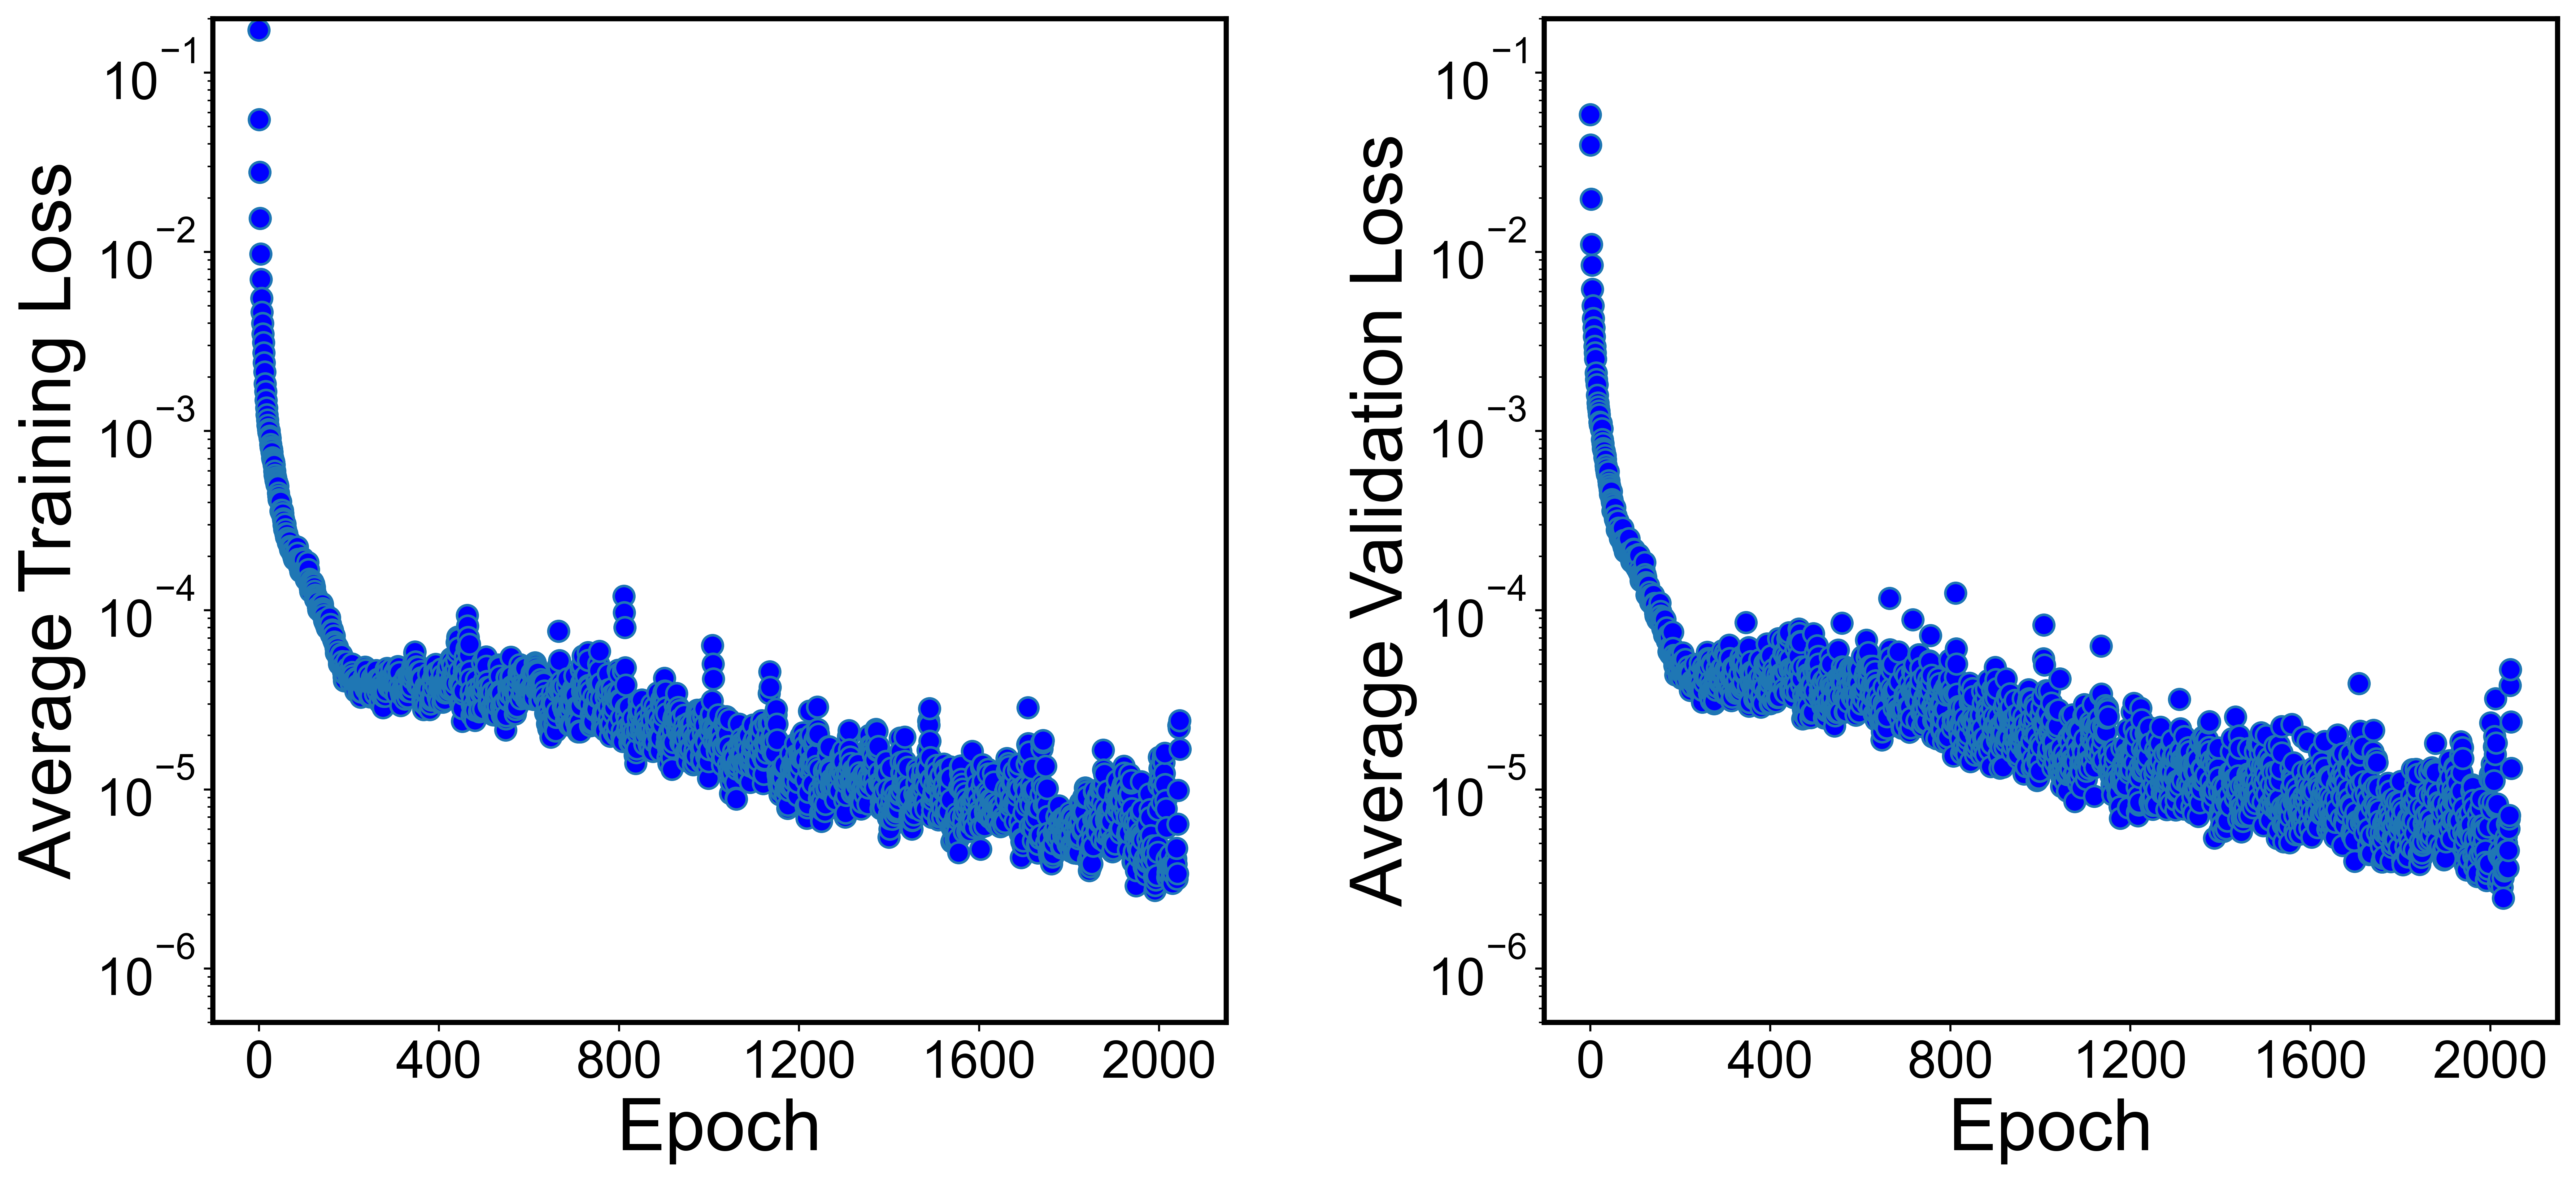

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,7.5), dpi=600)
#c = 1
loss_sum = np.zeros(np.shape(modelhistories[0].history['loss']))
val_loss_sum = np.zeros(np.shape(modelhistories[0].history['val_loss']))
for hist in modelhistories:
    #leg = "Model "+str(c)
    loss_sum += hist.history['loss']
    val_loss_sum += hist.history['val_loss']

loss_avg = loss_sum/len(modelhistories)
val_loss_avg = val_loss_sum/len(modelhistories)

ax[0].semilogy(loss_avg, marker='o', ms=8, mfc='b', linestyle='none')

ax[1].semilogy(val_loss_avg, marker='o', ms=8, mfc='b', linestyle='none')#, label=leg)

ax[0].set_ylabel('Average Training Loss', fontsize=28)
ax[1].set_ylabel('Average Validation Loss', fontsize=28)
for c in [0, 1]:
    ax[c].set_xlabel('Epoch', fontsize=28)

    ax[c].set_xticks(range(0,2001,400))
    ax[c].set_yticks([float(f'1e-{q}') for q in range(1,7)])
    ax[c].set_ylim([float(f'5e-7'), float(f'2e-1')])
    #ax[c].legend(loc='best', fontsize=20, ncol=2, markerscale = 1.5, columnspacing=0.8, 
    #         handletextpad=0.1, borderpad=0.3, framealpha=1, edgecolor='black')
    
    for tick in ax[c].xaxis.get_major_ticks():
        tick.label.set_fontsize(20)

    for tick in ax[c].yaxis.get_major_ticks():
        tick.label.set_fontsize(20)

fig.tight_layout(pad=2.0)
fig.savefig('Convergence_LS'+str(layersize)+'_DE'+str(depth)+'_avg_loss_2048.pdf')

(1024,)

[]